# Is there a correlation between median income and land surface temperature in the neighbourhoods of Toronto?

This analysis we aim to asses if there is a statistically signifcant corre

## Wrangle the data:

### Vector and attribute:
**Socioeconomic data** in .csv format has been retreived from the City of Toronto's Open Data Portal. However, this data is not appropriately formatted for our intents and purposes. Additionally, it lacks a geometry field. As such, it will be *cleaned*, *filtered*, *reshaped*, and *merged* with spatial data from a GeoJSON neighbourhood boundaries file, then *transformed* and visualized in QGIS.



In [1]:
"""Install libraries"""

# !pip install Pandas
# !pip install GeoPandas
# !pip install Folium
# !pip install matplotlib
# !pip install seaborn
# !pip install scipy
# !pip install rasterio
# !pip install leafmap
# !pip install xarray
# !pip install mapclassify
# !pip install rasterstats
# !pip install localtileserver

'Install libraries'

In [93]:
"""Import Libraries"""

import pandas as pd
import geopandas as gpd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import folium
import rasterio
from rasterio.mask import mask
from rasterio import Affine
from rasterio.enums import Resampling
import numpy as np
import leafmap
from rasterstats import zonal_stats

In [ ]:
"""Read the socioeconomic data into a DataFrame and preview the first 10 rows"""

neighbourhood_profiles_df = pd.read_csv("data/socioeconomic/to_nbh_profiles_2021.csv", header = 0)
neighbourhood_profiles_df.head(10)

Neighbourhood Name  \
0                               Neighbourhood Number   
1                              TSNS 2020 Designation   
2  Total - Age groups of the population - 25% sam...   
3                                      0 to 14 years   
4                                       0 to 4 years   
5                                       5 to 9 years   
6                                     10 to 14 years   
7                                     15 to 64 years   
8                                     15 to 19 years   
9                                     20 to 24 years   

                 West Humber-Clairville Mount Olive-Silverstone-Jamestown  \
0                                     1                                 2   
1  Not an NIA or Emerging Neighbourhood    Neighbourhood Improvement Area   
2                                 33300                             31345   
3                                  4295                              5690   
4                                  1460                              1650   
5                                  1345                              1860   
6                                  1485                              2175   
7                                 23640                             21490   
8                                  1860                              2280   
9                                  3175                              2675   

     Thistletown-Beaumond Heights                       Rexdale-Kipling  \
0                               3                                     4   
1  Neighbourhood Improvement Area  Not an NIA or Emerging Neighbourhood   
2                            9850                                 10375   
3                            1495                                  1575   
4                             505                                   505   
5                             540                                   615   
6                             455                                   455   
7                            6615                                  6950   
8                             570                                   515   
9                             745                                   715   

                 Elms-Old Rexdale   Kingsview Village-The Westway  \
0                               5                               6   
1  Neighbourhood Improvement Area  Neighbourhood Improvement Area   
2                            9355                           22005   
3                            1610                            3915   
4                             440                            1245   
5                             480                            1325   
6                             685                            1350   
7                            6355                           14385   
8                             635                            1245   
9                             685                            1605   

       Willowridge-Martingrove-Richview Humber Heights-Westmount  \
0                                     7                        8   
1  Not an NIA or Emerging Neighbourhood   Emerging Neighbourhood   
2                                 22445                    10005   
3                                  3500                     1370   
4                                  1065                      395   
5                                  1190                      430   
6                                  1240                      540   
7                                 13865                     6245   
8                                  1175                      525   
9                                  1330                      580   

               Edenbridge-Humber Valley  ...  \
0                                     9  ...   
1  Not an NIA or Emerging Neighbourhood  ...   
2                                 15190  ...   
3                                  2070  .

In [ ]:
"""Keep only the rows for "Neighbourhood Name", and "Median total income in 2020 among recipients ($)". Note, Neigbourhood Number is being dropped as it is not standerdized across data sets and therefore of no use"""

# Initailize a list of names to keep
row_names = [
    "Median total income in 2020  among recipients ($)",
    "Neighbourhood Name",
    ]

# Create a RegEx for search
pattern = "|".join([re.escape(name) for name in row_names])

# Filter for rows
filtered_df = neighbourhood_profiles_df[
    neighbourhood_profiles_df['Neighbourhood Name'].str.contains(pattern, na=False, regex=True)
]

# Reset the index
filtered_df = filtered_df.reset_index(drop = True)

filtered_df.head()

Neighbourhood Name West Humber-Clairville  \
0      Median total income in 2020  among recipie...                  33600   

  Mount Olive-Silverstone-Jamestown Thistletown-Beaumond Heights  \
0                             29600                        32800   

  Rexdale-Kipling Elms-Old Rexdale Kingsview Village-The Westway  \
0           33600            34400                         34400   

  Willowridge-Martingrove-Richview Humber Heights-Westmount  \
0                            40800                    40400   

  Edenbridge-Humber Valley  ... Harbourfront-CityPlace  \
0                    48400  ...                  58800   

  St Lawrence-East Bayfront-The Islands Church-Wellesley Downtown Yonge East  \
0                                 58000            42800               45200   

  Bay-Cloverhill Yonge-Bay Corridor Junction-Wallace Emerson  \
0          39600              44000                    41200   

  Dovercourt Village North Toronto South Eglinton-Davisville  
0              38000         46000                     52400  

[1 rows x 159 columns]

In [ ]:
"""Transpose the filtered df"""

transposed_df = filtered_df.T

transposed_df.head()

0
Neighbourhood Name                     Median total income in 2020  among recipie...
West Humber-Clairville                                                         33600
Mount Olive-Silverstone-Jamestown                                              29600
Thistletown-Beaumond Heights                                                   32800
Rexdale-Kipling                                                                33600

In [ ]:
"""Reset the indices and headers"""

transposed_df = transposed_df.reset_index()

transposed_df.columns = transposed_df.iloc[0]
result_df = transposed_df[1:].reset_index(drop = True)

result_df.head()

0                 Neighbourhood Name  \
0             West Humber-Clairville   
1  Mount Olive-Silverstone-Jamestown   
2       Thistletown-Beaumond Heights   
3                    Rexdale-Kipling   
4                   Elms-Old Rexdale   

0     Median total income in 2020  among recipients ($)  
0                                              33600     
1                                              29600     
2                                              32800     
3                                              33600     
4                                              34400

In [ ]:
"""Format the transposed df"""

# Rename
result_df.columns = ["nbh_name", "med_inc"]

# Ensure no whitespace
result_df.columns = result_df.columns.str.strip()

result_df.head()

nbh_name med_inc
0             West Humber-Clairville   33600
1  Mount Olive-Silverstone-Jamestown   29600
2       Thistletown-Beaumond Heights   32800
3                    Rexdale-Kipling   33600
4                   Elms-Old Rexdale   34400

In [ ]:
"""As data is being merged by "nbh_name" the strings must be normalized."""

def clean_name(name:str) -> str:
    return re.sub(r'\W+', '', name).lower() # Remove all non-alphanumeric chars and lowercase the string

result_df["mtch_name"] = result_df["nbh_name"].apply(clean_name)

result_df.head()

nbh_name med_inc                       mtch_name
0             West Humber-Clairville   33600            westhumberclairville
1  Mount Olive-Silverstone-Jamestown   29600  mountolivesilverstonejamestown
2       Thistletown-Beaumond Heights   32800      thistletownbeaumondheights
3                    Rexdale-Kipling   33600                  rexdalekipling
4                   Elms-Old Rexdale   34400                  elmsoldrexdale

In [ ]:
"""Check for null values"""

print(result_df.isnull().sum())

nbh_name     0
med_inc      0
mtch_name    0
dtype: int64


In [ ]:
"""Export to .csv"""

result_df.to_csv("data/socioeconomic/attribute_data.csv", index=False)

**Now we have successfully cleaned the data and outputted the result to a .csv.**

**Key Learnings:**
    -Watch out for spaces and special characters when parsing data --> regex is an effective solution!
    -Be catious with headers and indices when transposing tabular data.

**The next objective is to merge this data with the corresponding spatial data in the "neighbourhood_boundariesWGS84.geojson" file.**

In [ ]:
"""Open the GeoJSON containing the neighbourhood boundaries"""

geo_df = gpd.read_file("data/socioeconomic/neighbourhood_boundariesWGS84.geojson")

geo_df.to_csv("data/socioeconomic/nbh_bnds_tst.csv")

geo_df.head()

_id  AREA_ID  AREA_ATTR_ID  PARENT_AREA_ID AREA_SHORT_CODE AREA_LONG_CODE  \
0    1  2502366      26022881               0             174            174   
1    2  2502365      26022880               0             173            173   
2    3  2502364      26022879               0             172            172   
3    4  2502363      26022878               0             171            171   
4    5  2502362      26022877               0             170            170   

                   AREA_NAME                        AREA_DESC  \
0  South Eglinton-Davisville  South Eglinton-Davisville (174)   
1              North Toronto              North Toronto (173)   
2         Dovercourt Village         Dovercourt Village (172)   
3   Junction-Wallace Emerson   Junction-Wallace Emerson (171)   
4         Yonge-Bay Corridor         Yonge-Bay Corridor (170)   

                         CLASSIFICATION CLASSIFICATION_CODE    OBJECTID  \
0  Not an NIA or Emerging Neighbourhood                  NA  17824737.0   
1  Not an NIA or Emerging Neighbourhood                  NA  17824753.0   
2  Not an NIA or Emerging Neighbourhood                  NA  17824769.0   
3  Not an NIA or Emerging Neighbourhood                  NA  17824785.0   
4  Not an NIA or Emerging Neighbourhood                  NA  17824801.0   

                                            geometry  
0  MULTIPOLYGON (((-79.38635 43.69783, -79.38623 ...  
1  MULTIPOLYGON (((-79.39744 43.70693, -79.39837 ...  
2  MULTIPOLYGON (((-79.43411 43.66015, -79.43537 ...  
3  MULTIPOLYGON (((-79.4387 43.66766, -79.43841 4...  
4  MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ...

In [ ]:
"""Read the attribute data into a DataFrame"""

attribute_df = pd.read_csv("data/socioeconomic/attribute_data.csv")

attribute_df.head()

nbh_name  med_inc                       mtch_name
0             West Humber-Clairville    33600            westhumberclairville
1  Mount Olive-Silverstone-Jamestown    29600  mountolivesilverstonejamestown
2       Thistletown-Beaumond Heights    32800      thistletownbeaumondheights
3                    Rexdale-Kipling    33600                  rexdalekipling
4                   Elms-Old Rexdale    34400                  elmsoldrexdale

In [ ]:
"""Normalize the GeoJSON neighbourhood name formatting for merge"""

def clean_name(name:str) -> str:
    return re.sub(r'\W+', '', name).lower() # Remove all non-alphanumeric chars and lowercase the string

geo_df["mtch_name"] = geo_df["AREA_NAME"].apply(clean_name)
geo_df.head()

_id  AREA_ID  AREA_ATTR_ID  PARENT_AREA_ID AREA_SHORT_CODE AREA_LONG_CODE  \
0    1  2502366      26022881               0             174            174   
1    2  2502365      26022880               0             173            173   
2    3  2502364      26022879               0             172            172   
3    4  2502363      26022878               0             171            171   
4    5  2502362      26022877               0             170            170   

                   AREA_NAME                        AREA_DESC  \
0  South Eglinton-Davisville  South Eglinton-Davisville (174)   
1              North Toronto              North Toronto (173)   
2         Dovercourt Village         Dovercourt Village (172)   
3   Junction-Wallace Emerson   Junction-Wallace Emerson (171)   
4         Yonge-Bay Corridor         Yonge-Bay Corridor (170)   

                         CLASSIFICATION CLASSIFICATION_CODE    OBJECTID  \
0  Not an NIA or Emerging Neighbourhood                  NA  17824737.0   
1  Not an NIA or Emerging Neighbourhood                  NA  17824753.0   
2  Not an NIA or Emerging Neighbourhood                  NA  17824769.0   
3  Not an NIA or Emerging Neighbourhood                  NA  17824785.0   
4  Not an NIA or Emerging Neighbourhood                  NA  17824801.0   

                                            geometry                mtch_name  
0  MULTIPOLYGON (((-79.38635 43.69783, -79.38623 ...  southeglintondavisville  
1  MULTIPOLYGON (((-79.39744 43.70693, -79.39837 ...             northtoronto  
2  MULTIPOLYGON (((-79.43411 43.66015, -79.43537 ...        dovercourtvillage  
3  MULTIPOLYGON (((-79.4387 43.66766, -79.43841 4...   junctionwallaceemerson  
4  MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ...         yongebaycorridor

In [ ]:
"""Merge the two datasets"""

merged_df = geo_df.merge(attribute_df, left_on = "mtch_name", right_on = "mtch_name")

merged_df

_id  AREA_ID  AREA_ATTR_ID  PARENT_AREA_ID AREA_SHORT_CODE  \
0      1  2502366      26022881               0             174   
1      2  2502365      26022880               0             173   
2      3  2502364      26022879               0             172   
3      4  2502363      26022878               0             171   
4      5  2502362      26022877               0             170   
..   ...      ...           ...             ...             ...   
153  154  2502213      26022728               0             001   
154  155  2502212      26022727               0             024   
155  156  2502211      26022726               0             023   
156  157  2502210      26022725               0             022   
157  158  2502209      26022724               0             021   

    AREA_LONG_CODE                  AREA_NAME  \
0              174  South Eglinton-Davisville   
1              173              North Toronto   
2              172         Dovercourt Village   
3              171   Junction-Wallace Emerson   
4              170         Yonge-Bay Corridor   
..             ...                        ...   
153            001     West Humber-Clairville   
154            024                Black Creek   
155            023       Pelmo Park-Humberlea   
156            022                 Humbermede   
157            021              Humber Summit   

                           AREA_DESC                        CLASSIFICATION  \
0    South Eglinton-Davisville (174)  Not an NIA or Emerging Neighbourhood   
1                North Toronto (173)  Not an NIA or Emerging Neighbourhood   
2           Dovercourt Village (172)  Not an NIA or Emerging Neighbourhood   
3     Junction-Wallace Emerson (171)  Not an NIA or Emerging Neighbourhood   
4           Yonge-Bay Corridor (170)  Not an NIA or Emerging Neighbourhood   
..                               ...                                   ...   
153       West Humber-Clairville (1)  Not an NIA or Emerging Neighbourhood   
154                 Black Creek (24)        Neighbourhood Improvement Area   
155        Pelmo Park-Humberlea (23)  Not an NIA or Emerging Neighbourhood   
156                  Humbermede (22)        Neighbourhood Improvement Area   
157               Humber Summit (21)        Neighbourhood Improvement Area   

    CLASSIFICATION_CODE    OBJECTID  \
0                    NA  17824737.0   
1                    NA  17824753.0   
2                    NA  17824769.0   
3                    NA  17824785.0   
4                    NA  17824801.0   
..                  ...         ...   
153                  NA  17827185.0   
154                 NIA  17827201.0   
155                  NA  17827217.0   
156                 NIA  17827233.0   
157                 NIA  17827249.0   

                                              geometry  \
0    MULTIPOLYGON (((-79.38635 43.69783, -79.38623 ...   
1    MULTIPOLYGON (((-79.39744 43.70693, -79.39837 ...   
2    MULTIPOLYGON (((-79.43411 43.66015, -79.43537 ...   
3    MULTIPOLYGON (((-79.4387 43.66766, -79.43841 4...   
4    MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ...   
..                                                 ...   
153  MULTIPOLYGON (((-79.59037 43.73401, -79.58942 ...   
154  MULTIPOLYGON (((-79.51915 43.77399, -79.51901 ...   
155  MULTIPOLYGON (((-79.53225 43.73505, -79.52938 ...   
156  MULTIPOLYGON (((-79.52813 43.74425, -79.52721 ...   
157  MULTIPOLYGON (((-79.53396 43.76886, -79.53227 ...   

                   mtch_name                   nbh_name  med_inc  
0    southeglintondavisville  South Eglinton-Davisville    52400  
1               northtoronto              North Toronto    46000  
2          dovercourtvillage         Dovercourt Village    38000  
3     junctionwallaceemerson   Junction-Wallace Emerson    41200  
4           yongebaycorridor         Yonge-Bay Corridor    44000  
..                       ...                        ...      ...  
153     westhumberclairville     West H

In [ ]:
"""Filter for the unique ids, neighbourhood names, 2020 median income, and geometry fields"""

# Filter 
filtered_df = merged_df[["_id", "nbh_name", "med_inc", "geometry"]]

# Rename unique_id to id
result_df = filtered_df.rename(columns = {"_id": "id"})

result_df

id                   nbh_name  med_inc  \
0      1  South Eglinton-Davisville    52400   
1      2              North Toronto    46000   
2      3         Dovercourt Village    38000   
3      4   Junction-Wallace Emerson    41200   
4      5         Yonge-Bay Corridor    44000   
..   ...                        ...      ...   
153  154     West Humber-Clairville    33600   
154  155                Black Creek    29400   
155  156       Pelmo Park-Humberlea    39600   
156  157                 Humbermede    32400   
157  158              Humber Summit    31200   

                                              geometry  
0    MULTIPOLYGON (((-79.38635 43.69783, -79.38623 ...  
1    MULTIPOLYGON (((-79.39744 43.70693, -79.39837 ...  
2    MULTIPOLYGON (((-79.43411 43.66015, -79.43537 ...  
3    MULTIPOLYGON (((-79.4387 43.66766, -79.43841 4...  
4    MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ...  
..                                                 ...  
153  MULTIPOLYGON (((-79.59037 43.73401, -79.58942 ...  
154  MULTIPOLYGON (((-79.51915 43.77399, -79.51901 ...  
155  MULTIPOLYGON (((-79.53225 43.73505, -79.52938 ...  
156  MULTIPOLYGON (((-79.52813 43.74425, -79.52721 ...  
157  MULTIPOLYGON (((-79.53396 43.76886, -79.53227 ...  

[158 rows x 4 columns]

In [ ]:
"""Verify geometry and coordinate reference system (CRS)"""

print(result_df.geometry.head())
print(result_df.crs)

0    MULTIPOLYGON (((-79.38635 43.69783, -79.38623 ...
1    MULTIPOLYGON (((-79.39744 43.70693, -79.39837 ...
2    MULTIPOLYGON (((-79.43411 43.66015, -79.43537 ...
3    MULTIPOLYGON (((-79.4387 43.66766, -79.43841 4...
4    MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ...
Name: geometry, dtype: geometry
EPSG:4326


In [ ]:
"""Visualize geospatial distribution of median income with an interactive map"""

result_df.explore(tooltip=["nbh_name", "med_inc"],
                  column="med_inc",
                  cmap="Greens",
                  legend=True,
                  style_kwds={"color": "black",
                              "weight": 1,
                              "fillOpacity": 0.8,
                              }
                  )

In [ ]:
"""Export to a shapefile"""

nbh_map_path = "data/socioeconomic/toronto_nbh_2020.shp"

result_df.to_file(nbh_map_path)

## Derivation of LST

### Calculation of Normalized Difference Vegetation Index (NDVI)

To calculate the NDVI we perform band math. The formula is given as:

$

### Landsat 8-9 Band Designations
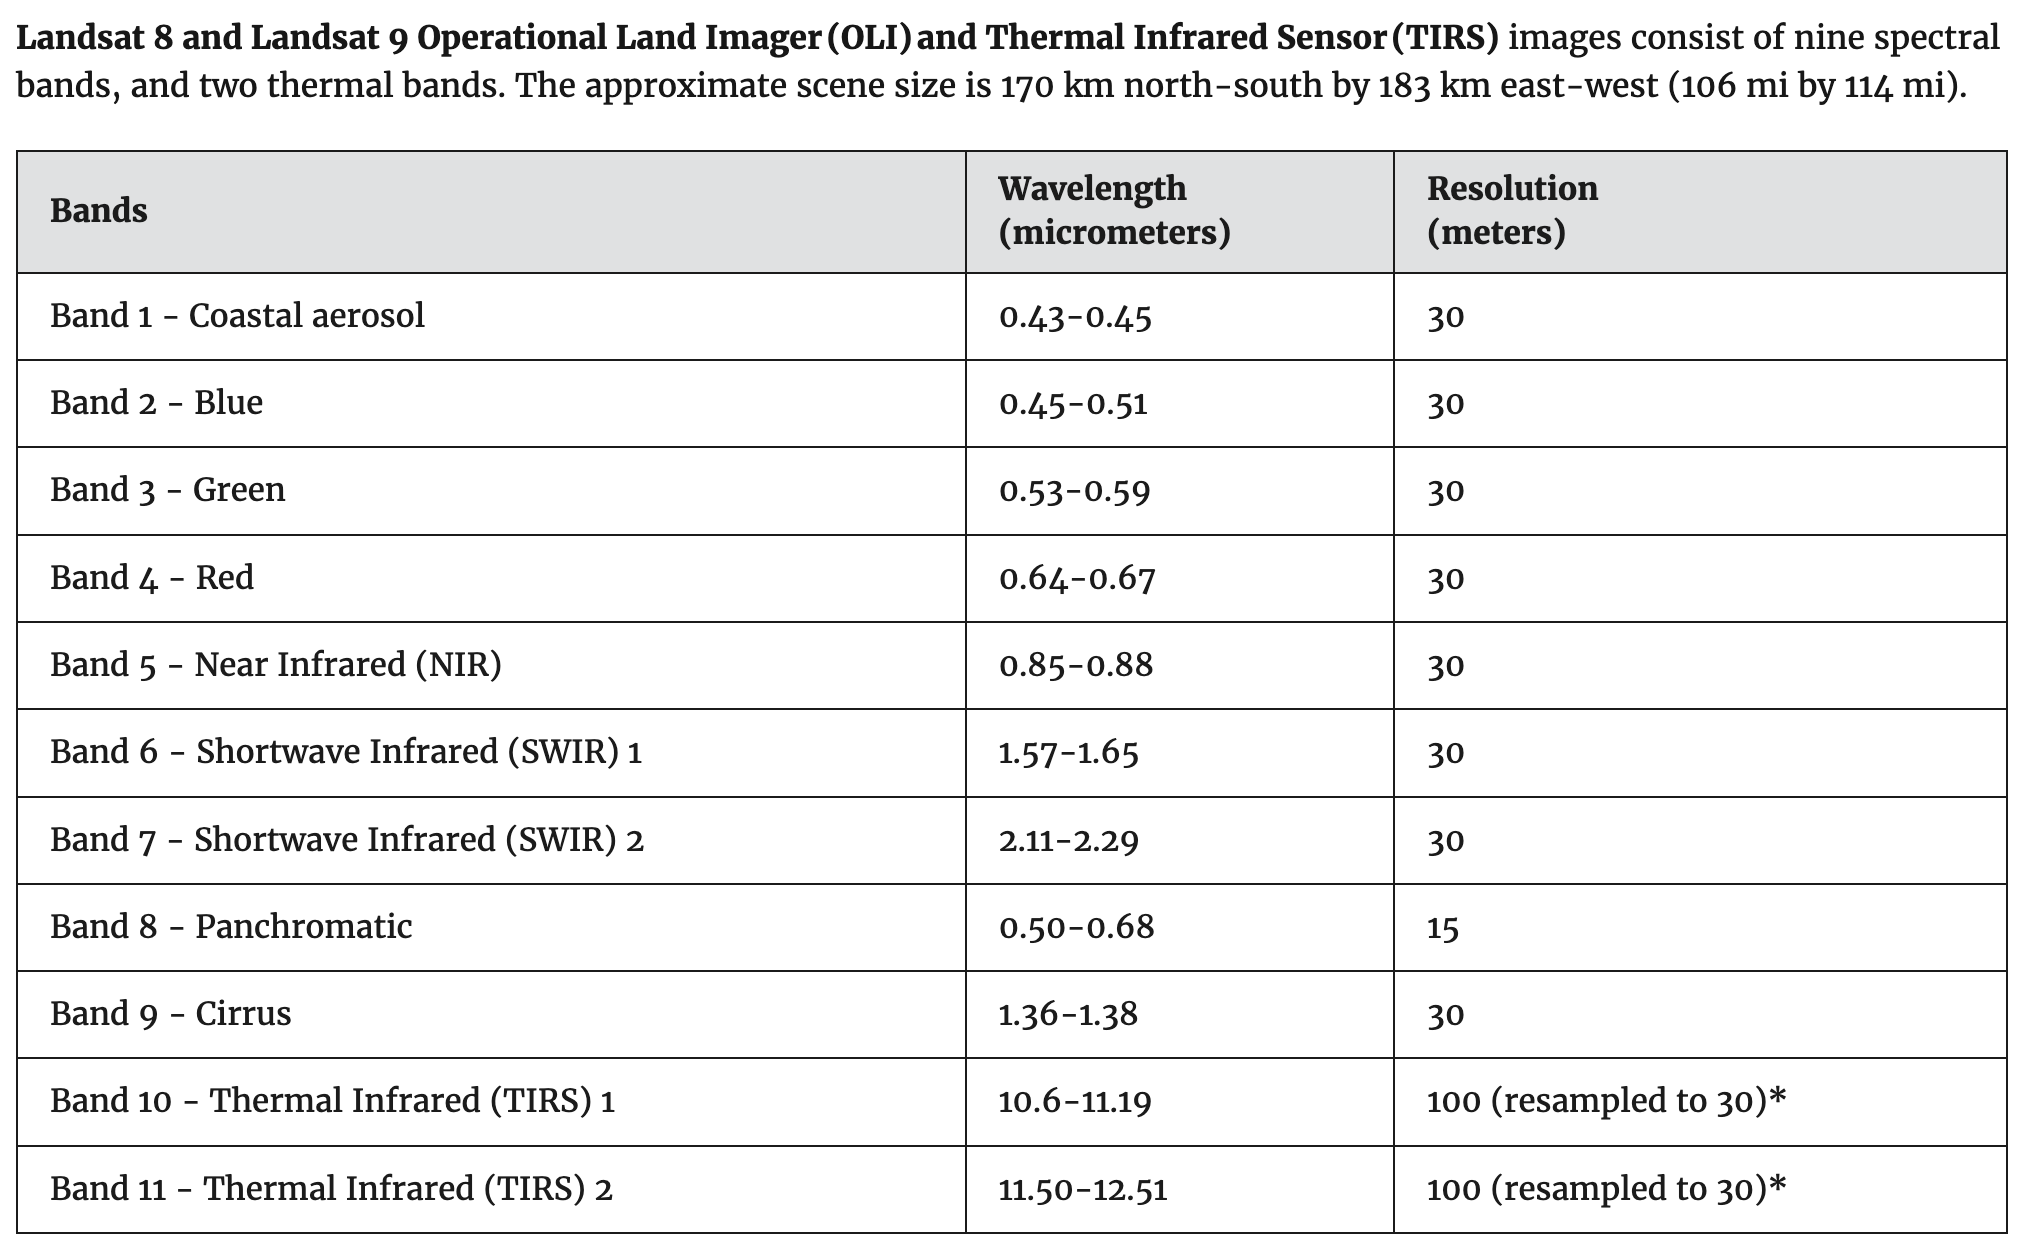

In [ ]:
"""Define useful variables for band math"""

# File paths
band2_blue_path = "data/rs/LC08_L1TP_018030_20200702_20200913_02_T1_B2.TIF"
band3_green_path = "data/rs/LC08_L1TP_018030_20200702_20200913_02_T1_B3.TIF"
band4_red_path = "data/rs/LC08_L1TP_018030_20200702_20200913_02_T1_B4.TIF"
band5_nir_path = "data/rs/LC08_L1TP_018030_20200702_20200913_02_T1_B5.TIF"
band10_tirs_path = "data/rs/LC08_L1TP_018030_20200702_20200913_02_T1_B10.TIF"

# Rescaling factors retrieved from data/rs/LC08_L1TP_018030_20200702_20200913_02_T1_MTL.txt
rad_add_band10 = 0.1
rad_mlt_band10 = 3.3420e-04

# Thermal constants retrieved from data/rs/LC08_L1TP_018030_20200702_20200913_02_T1_MTL.txt
k1_band10 = 774.8853
k2_band10 = 1321.0789

In [ ]:
"""Calculate Top of Atmosphere Radiance (TOA)"""

# Open file and check meta
with rasterio.open(band10_tirs_path) as tirs_src:
    band10_tirs = tirs_src.read(1).astype("float32")
    band10_tirs_meta = tirs_src.meta

print(f"Band 10 TIRS meta: {band10_tirs_meta}")

# Calculate
toa = rad_mlt_band10 * band10_tirs + rad_add_band10
type(toa)

Band 10 TIRS meta: {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 7731, 'height': 7851, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32617"]]'), 'transform': Affine(30.0, 0.0, 456585.0,
       0.0, -30.0, 4899015.0)}


numpy.ndarray

In [ ]:
"""Convert TOA to Brightness Temperature (BT)"""

# First to Kelvin
bt_kelvin = k2_band10 / np.log(k1_band10 / toa) + 1 # np.log = ln()

# Convert to Celcius
bt = bt_kelvin - 273.15 

type(bt)

numpy.ndarray

In [ ]:
"""Calcualate Normalized Difference Vegetation Index (NDVI)"""

# Open NIR and Red band files
with rasterio.open(band4_red_path) as red_src:
    band4_red = red_src.read(1).astype("float32")
    meta = red_src.meta.copy()

print(f"Original metadata: {meta}") # For manual inspection

with rasterio.open(band5_nir_path) as nir_src:
    band5_nir = nir_src.read(1).astype("float32")

# Handle zero division error with mask
valid_mask = (band5_nir + band4_red) != 0

ndvi = np.where(valid_mask, 
                (band5_nir - band4_red) / (band5_nir + band4_red), 
                -9999)

# Update metadata for NDVI (float values and nodata)
meta.update({
    "dtype": "float32",
    "nodata": -9999
})

print(f"Updated metadata: {meta}") # For manual inspection

ndvi_path = "data/rs/ndvi.tif"

# Export to GeoTIFF
with rasterio.open(ndvi_path, "w", **meta) as ndvi_dst:
    ndvi_dst.write(ndvi.astype("float32"), 1)

Original metadata: {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 7731, 'height': 7851, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32617"]]'), 'transform': Affine(30.0, 0.0, 456585.0,
       0.0, -30.0, 4899015.0)}
Updated metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999, 'width': 7731, 'height': 7851, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DAT

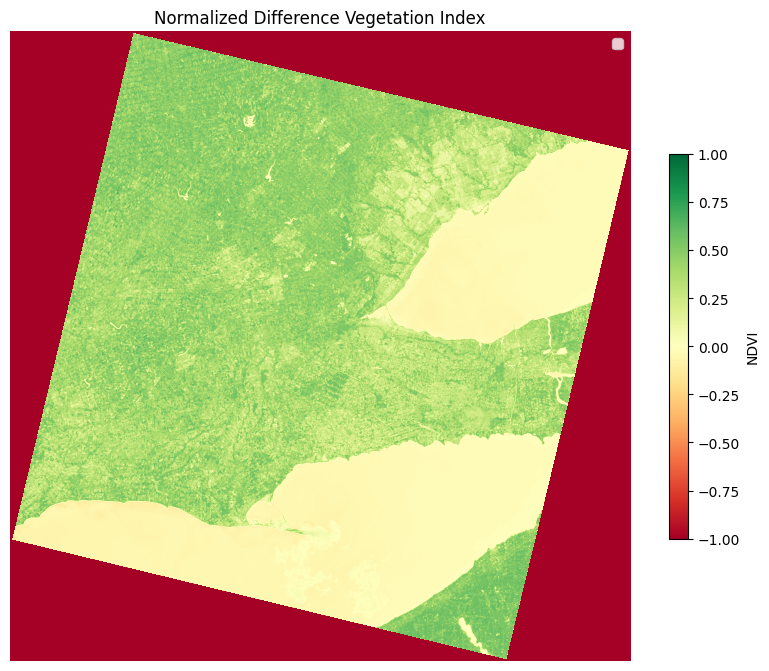

In [ ]:
"""Visually assess NDVI map"""

plt.figure(figsize=[10, 10])
plt.title("Normalized Difference Vegetation Index")
plt.legend(ndvi)
plt.axis("off")
img = plt.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)

cbar = plt.colorbar(img, shrink=0.5)
cbar.set_label("NDVI")

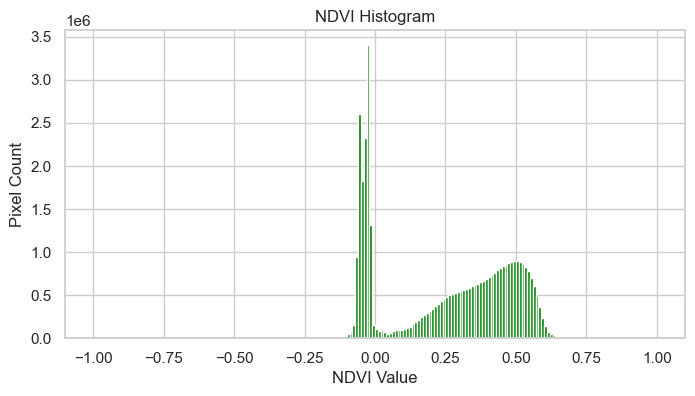

In [55]:
"""Visually assess the NDVI histogram"""

# Mask invalid or nodata values
display_ndvi = np.where(ndvi == -9999, np.nan, ndvi)

# Create Histogram
plt.figure(figsize=(8, 4))
plt.hist(display_ndvi[~np.isnan(ndvi)], bins=200, color='green')
plt.title("NDVI Histogram")
plt.xlabel("NDVI Value")
plt.ylabel("Pixel Count")
plt.grid(True)
plt.show()

In [ ]:
"""Estimate Proportion of Vegetation (Pv)"""

# Define max and min NDVI
ndvi_min = -0.17614
ndvi_max = 0.660447

# Calculate Pv
pv = np.square((ndvi - np.absolute(ndvi_min)) / (ndvi_max - np.absolute(ndvi_min)))

type(pv)

numpy.ndarray

In [59]:
"""Estimate Emissivity (E)"""

emis = 0.004 * pv + 0.986

type(emis)

numpy.ndarray

In [ ]:
"""Derive an approximation for LST"""

# Calculate
lst = bt / (1 + (10.8 * bt / 14388) * np.log(emis))

print(type(lst))

# Update metadata
lst_meta = band10_tirs_meta.copy()

lst_meta.update({
    "dtype": "float32",
    "nodata": -9999
})

print(f"Updated metadata: {lst_meta}")

lst_path = "data/rs/lst.tif"

# Write to file
with rasterio.open(lst_path, "w", **lst_meta) as lst_dst:
    lst_dst.write(lst.astype("float32"), 1)

<class 'numpy.ndarray'>
Updated metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999, 'width': 7731, 'height': 7851, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32617"]]'), 'transform': Affine(30.0, 0.0, 456585.0,
       0.0, -30.0, 4899015.0)}


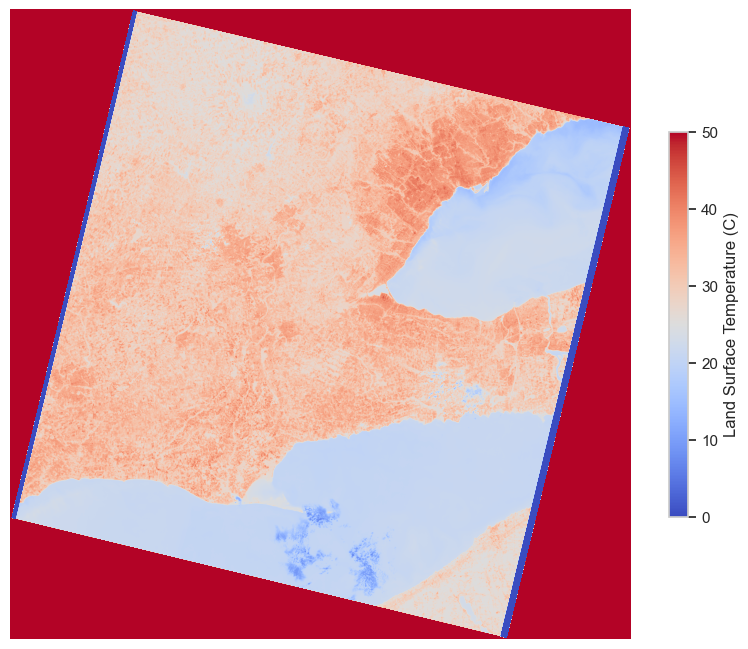

In [62]:
"""Visualize LST"""

plt.figure(figsize=[10, 10])
plt.axis("off")
img = plt.imshow(lst, cmap="coolwarm", vmin=0, vmax=50)

cbar = plt.colorbar(img, shrink=0.5)
cbar.set_label("Land Surface Temperature (C)")

In [63]:
"""Open LST raster data and neighbourhood vector data and configure CRS"""

# Open vector data
nbhs = gpd.read_file(nbh_map_path)
print(f"nbh type: {type(nbhs)}, CRS: {nbhs.crs}")

# Open raster data
lst = rasterio.open(lst_path)
print(f"lst type: {type(lst)}, CRS: {lst.crs}")

# Match CRS
nbhs = nbhs.to_crs(lst.crs)
print(f"CRS match: {nbhs.crs == lst.crs}")

nbh type: <class 'geopandas.geodataframe.GeoDataFrame'>, CRS: EPSG:4326
lst type: <class 'rasterio.io.DatasetReader'>, CRS: EPSG:32617
CRS match: True


In [65]:
"""Extract geometry"""

geometry = nbhs.geometry
geojson_geom = [feature.__geo_interface__ for feature in geometry]

print(type(geojson_geom))

<class 'list'>


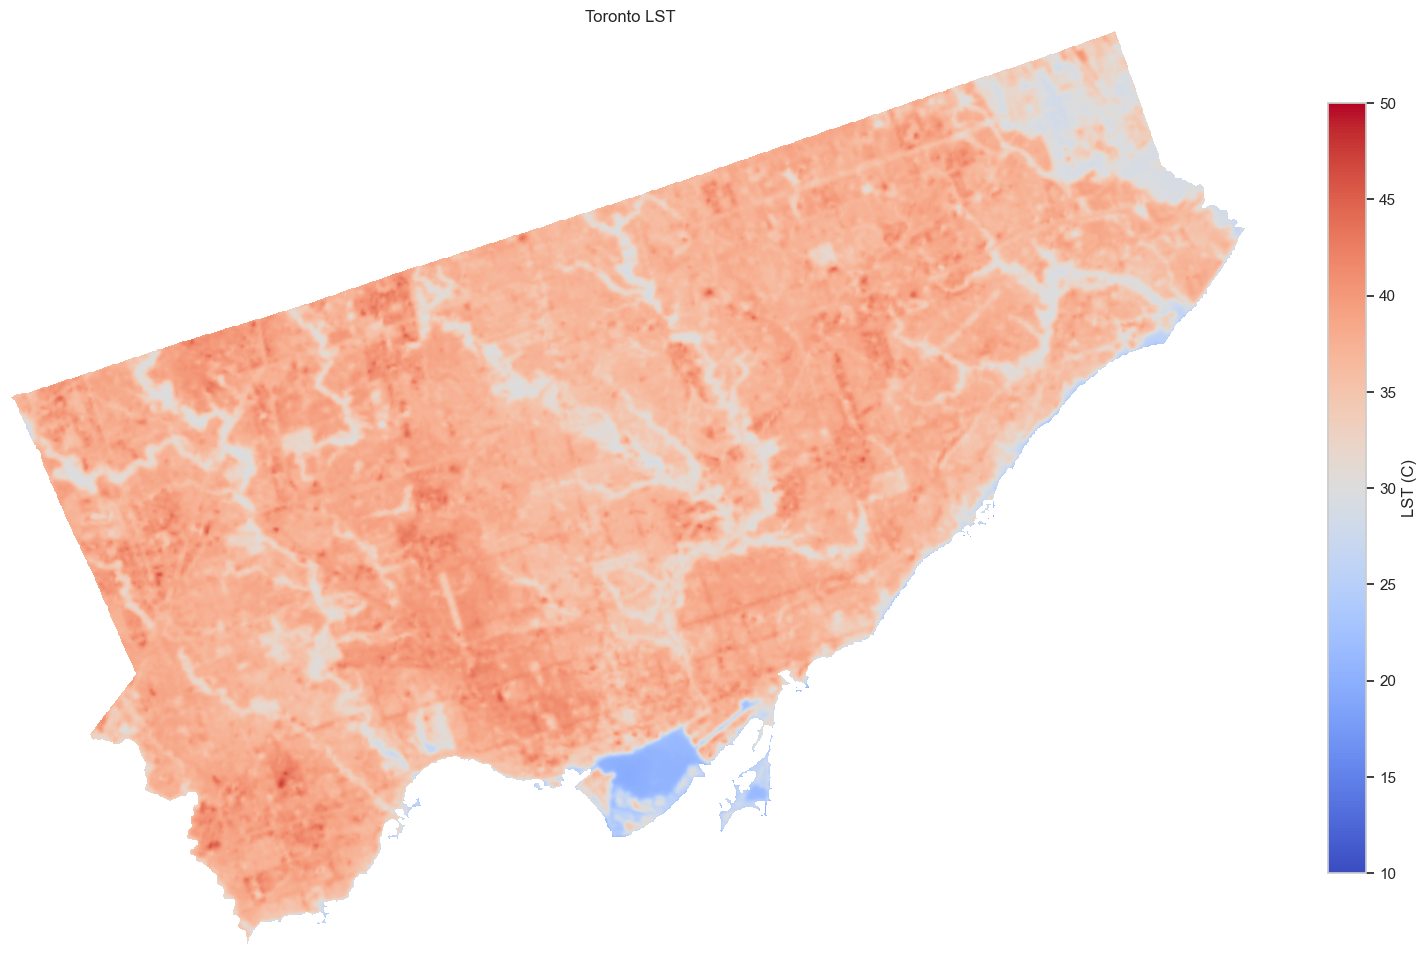

In [ ]:
"""Clip the LST raster and visualize"""

clipped_raster, clipped_transform = mask(dataset=lst, shapes=geojson_geom, crop=True)

# Handle nodata values for visualization
display_raster = np.where(clipped_raster == -9999, np.nan, clipped_raster)

plt.figure(figsize=[20, 20])
plt.imshow(display_raster[0], cmap="coolwarm", vmin=10, vmax=50)
plt.colorbar(label="LST (C)", shrink=0.5)
plt.title("Toronto LST")
plt.axis("off")
plt.show()

In [67]:
"""Save the clipped LST raster to a file"""

# Update metadata
out_meta = lst.meta.copy()

out_meta.update({
    "height": clipped_raster.shape[1],
    "width": clipped_raster.shape[2],
    "transform": clipped_transform
})

toronto_lst_path = "data/rs/toronto_lst.tif"

# Write to a .TIF
with rasterio.open(toronto_lst_path, "w", **out_meta) as toronto_lst:
    toronto_lst.write(clipped_raster)

In [68]:
"""Open NDVI raster data and neighbourhood vector data and configure CRS"""

# Open vector data
nbhs = gpd.read_file(nbh_map_path)
print(f"nbh type: {type(nbhs)}, CRS: {nbhs.crs}")

# Open raster data
ndvi = rasterio.open(ndvi_path)
print(f"ndvi type: {type(ndvi)}, CRS: {ndvi.crs}")

# Match CRS
nbhs = nbhs.to_crs(ndvi.crs)
print(f"CRS match: {nbhs.crs == ndvi.crs}")

nbh type: <class 'geopandas.geodataframe.GeoDataFrame'>, CRS: EPSG:4326
ndvi type: <class 'rasterio.io.DatasetReader'>, CRS: EPSG:32617
CRS match: True


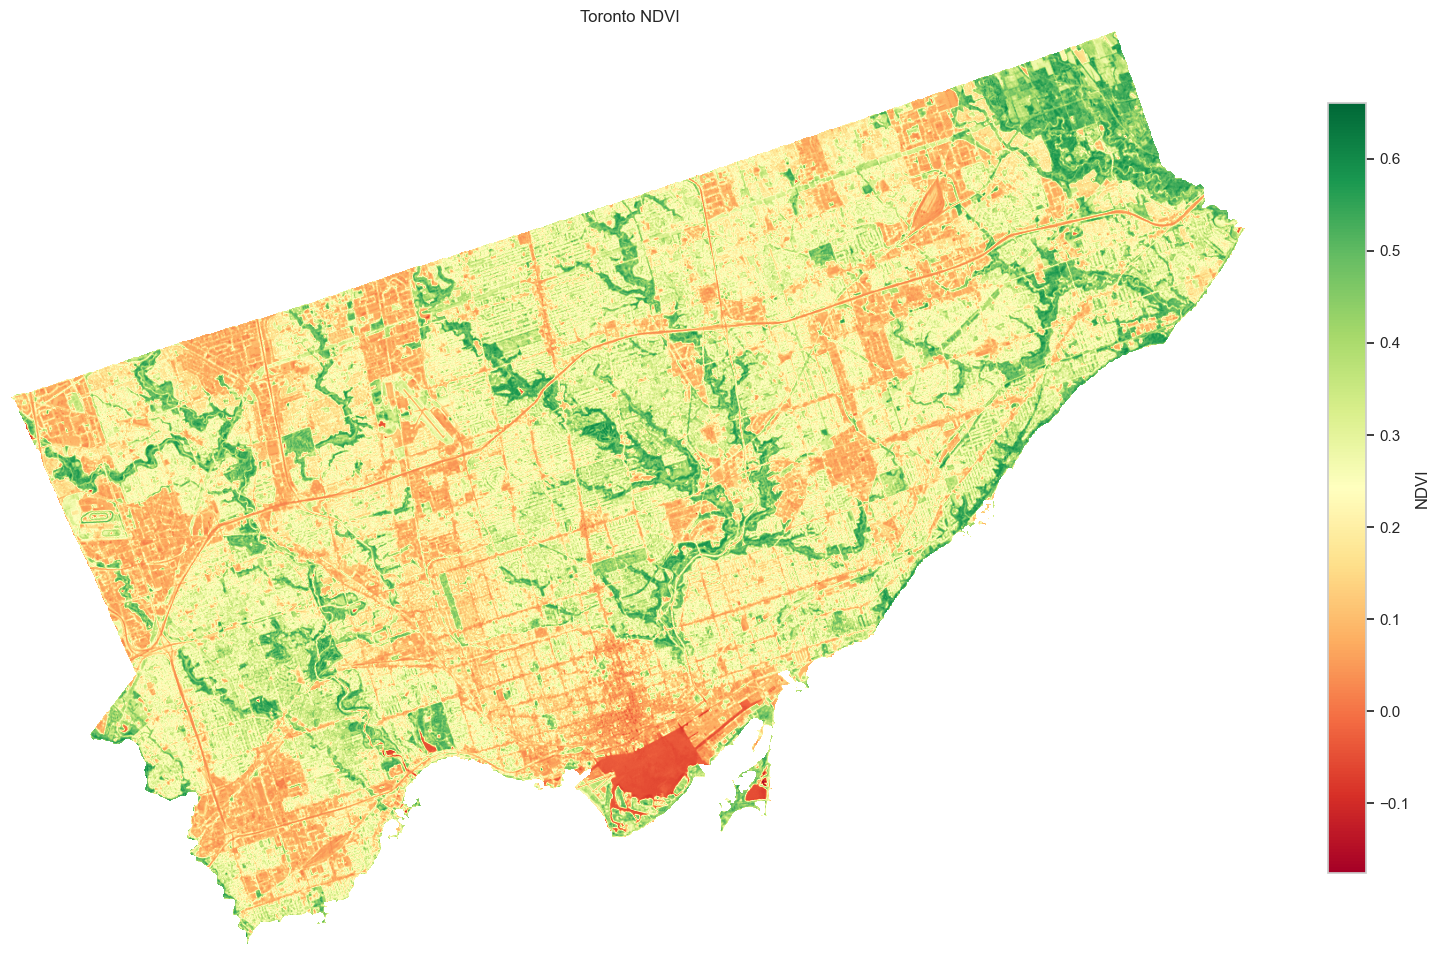

In [79]:
"""Clip the NDVI raster and visualize"""

clipped_raster, clipped_transform = mask(dataset=ndvi, shapes=geojson_geom, crop=True)

# Handle nodata values for visualization
display_raster = np.where(clipped_raster == -9999, np.nan, clipped_raster)

plt.figure(figsize=[20, 20])
plt.imshow(display_raster[0], cmap="RdYlGn", vmin=ndvi_min, vmax=ndvi_max)
plt.colorbar(label="NDVI", shrink=0.5)
plt.title("Toronto NDVI")
plt.axis("off")
plt.show()

In [80]:
"""Save the clipped NDVI raster to a file"""

# Update meta
out_meta = ndvi.meta.copy()

out_meta.update({
    "height": clipped_raster.shape[1],
    "width": clipped_raster.shape[2],
    "transform": clipped_transform
})

toronto_ndvi_path = "data/rs/toronto_ndvi.tif"

# Write to file
with rasterio.open(toronto_ndvi_path, "w", **out_meta) as toronto_ndvi:
    toronto_ndvi.write(clipped_raster)

## Zonal Statistics
All data is prepped. LST and NDVI zonal statistics will be extracted.

In [81]:
"""Open data and ensure matching CRS"""

nbhs = gpd.read_file(nbh_map_path)

with rasterio.open(toronto_lst_path) as toronto_lst_src:
    toronto_lst_crs = toronto_lst.crs

nbhs = nbhs.to_crs(toronto_lst_crs)

print(toronto_lst_crs == nbhs.crs)

True


In [82]:
"""Calculate zonal statistics and export to geoJSON"""

# Calculate LST zonal stats
stats = zonal_stats(
    nbhs,
    toronto_lst_path,
    stats=["min", "max", "mean", "median", "majority"],
    nodata=-9999,
    geojson_out=True
)

# Change field names
for feature in stats:
    props = feature["properties"]
    props["lst_min"] = props.pop("min")
    props["lst_max"] = props.pop("max")
    props["lst_mean"] = props.pop("mean")
    props["lst_median"] = props.pop("median")
    props["lst_mode"] = props.pop("majority")

# Read to GeoPandas GeoDataFrame
lst_stats = gpd.GeoDataFrame.from_features(stats)

# Reproject and check CRS
lst_stats.set_crs(nbhs.crs, inplace=True)
print(lst_stats.crs)

# Calculate NDVI zonal stats
ndvi_stats_raw = zonal_stats(
    nbhs,
    toronto_ndvi_path,
    stats=["min", "max", "mean", "median", "majority"],
    nodata=-9999,
    geojson_out=False
)

# Add NDVI stats to the same GeoDataFrame
for i, props in enumerate(ndvi_stats_raw):
    lst_stats.loc[i, "ndvi_min"] = props["min"]
    lst_stats.loc[i, "ndvi_max"] = props["max"]
    lst_stats.loc[i, "ndvi_mean"] = props["mean"]
    lst_stats.loc[i, "ndvi_median"] = props["median"]
    lst_stats.loc[i, "ndvi_mode"] = props["majority"]

# Reproject to WGS84
lst_stats.to_crs(epsg=4326)
print(lst_stats.crs)

toronto_inc_lst_path = "data/toronto_inc_lst.geojson"

# Export to GeoJSON
lst_stats.to_file(toronto_inc_lst_path, driver="GeoJSON")

lst_stats.head()

PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32617"]]
PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["

geometry  id  \
0  POLYGON ((630028.458 4839577.663, 630038.986 4...   1   
1  POLYGON ((629115.632 4840570.87, 629041.14 484...   2   
2  POLYGON ((626258.743 4835318.329, 626158.284 4...   3   
3  POLYGON ((625873.19 4836146.058, 625898.171 48...   4   
4  POLYGON ((630329.072 4833709.787, 630250.316 4...   5   

                    nbh_name  med_inc    lst_min    lst_max   lst_mean  \
0  South Eglinton-Davisville    52400  33.744450  39.629379  36.327902   
1              North Toronto    46000  34.083881  38.563488  35.930071   
2         Dovercourt Village    38000  34.158615  41.481365  39.320662   
3   Junction-Wallace Emerson    41200  37.131489  43.251816  40.214606   
4         Yonge-Bay Corridor    44000  31.586926  39.635574  35.505678   

   lst_median   lst_mode  ndvi_min  ndvi_max  ndvi_mean  ndvi_median  \
0   36.367973  36.545925 -0.009211  0.520741   0.217415     0.213127   
1   35.879845  34.671337 -0.006708  0.428062   0.144093     0.135098   
2   39.530499  39.926041  0.011149  0.504825   0.186680     0.175555   
3   40.269840  40.123352  0.011513  0.483600   0.156227     0.146283   
4   35.670750  35.507446 -0.054280  0.439842   0.067951     0.053026   

   ndvi_mode  
0  -0.009211  
1  -0.006708  
2   0.011149  
3   0.011513  
4  -0.054280

## Data Analysis
### Data inspection

In [83]:
"""Read the Data"""

toronto_inc_lst = gpd.read_file(toronto_inc_lst_path)

toronto_inc_lst.head()

id                   nbh_name  med_inc    lst_min    lst_max   lst_mean  \
0   1  South Eglinton-Davisville    52400  33.744450  39.629379  36.327902   
1   2              North Toronto    46000  34.083881  38.563488  35.930071   
2   3         Dovercourt Village    38000  34.158615  41.481365  39.320662   
3   4   Junction-Wallace Emerson    41200  37.131489  43.251816  40.214606   
4   5         Yonge-Bay Corridor    44000  31.586926  39.635574  35.505678   

   lst_median   lst_mode  ndvi_min  ndvi_max  ndvi_mean  ndvi_median  \
0   36.367973  36.545925 -0.009211  0.520741   0.217415     0.213127   
1   35.879845  34.671337 -0.006708  0.428062   0.144093     0.135098   
2   39.530499  39.926041  0.011149  0.504825   0.186680     0.175555   
3   40.269840  40.123352  0.011513  0.483600   0.156227     0.146283   
4   35.670750  35.507446 -0.054280  0.439842   0.067951     0.053026   

   ndvi_mode                                           geometry  
0  -0.009211  POLYGON ((630028.458 4839577.663, 630038.986 4...  
1  -0.006708  POLYGON ((629115.632 4840570.87, 629041.14 484...  
2   0.011149  POLYGON ((626258.743 4835318.329, 626158.284 4...  
3   0.011513  POLYGON ((625873.19 4836146.058, 625898.171 48...  
4  -0.054280  POLYGON ((630329.072 4833709.787, 630250.316 4...

In [ ]:
"""Check the data for nulls and appropriate types"""

divider = "----------------------------------------------------------------------"

print(toronto_inc_lst.isnull().sum())
print(divider)
print(toronto_inc_lst.describe())
print(divider)
print(toronto_inc_lst.dtypes)


id             0
nbh_name       0
med_inc        0
lst_min        0
lst_max        0
lst_mean       0
lst_median     0
lst_mode       0
ndvi_min       0
ndvi_max       0
ndvi_mean      0
ndvi_median    0
ndvi_mode      0
geometry       0
dtype: int64
----------------------------------------------------------------------
               id       med_inc     lst_min     lst_max    lst_mean  \
count  158.000000    158.000000  158.000000  158.000000  158.000000   
mean    79.500000  41985.443038   30.812587   41.390755   36.760131   
std     45.754781  10216.302857    3.860074    1.733399    1.711383   
min      1.000000  28400.000000   18.035746   38.272873   26.674012   
25%     40.250000  34000.000000   29.717181   40.061166   35.865759   
50%     79.500000  39000.000000   30.920043   41.170923   36.930434   
75%    118.750000  46400.000000   33.471794   42.500403   37.694911   
max    158.000000  74500.000000   37.452763   47.439240   40.214606   

       lst_median    lst_mode    ndvi_

### Data Exploration and Formulation of Hypothesis

In [86]:
"""Visualize the data with an interactive map"""

# Initialize a map centered on Toronto
m = leafmap.Map(center=[43.7, -79.42], zoom=20, basemap="Esri.WorldTopoMap", toolbar=False, draw_toolbar=False, search_control=True, layers_control=True, use_leaflet=True)

# Add NDVI layer
m.add_raster(toronto_ndvi_path, layer_name="NDVI", colormap="RdYlGn", nodata=-9999)

# Add LST layer
m.add_raster(toronto_lst_path, layer_name="LST", colormap="coolwarm", nodata=-9999)

# Add neighborhood boundaries as a GeoJSON layer with tooltips
m.add_gdf(toronto_inc_lst,
        layer_name="Neighborhoods",
        tooltip=["nbh_name", 
            "med_inc",
            "lst_min",
            "lst_max",
            "lst_mean",
            "lst_median",
            "lst_mode",
            "ndvi_mode"],
        style={"color": "black", "weight": 1, "fillOpacity": 0.0},
        )

# Display the map
m

Map(center=[43.718443, -79.3782845], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

### Analysis of Bivariate Relationships
#### Normality Testing
##### Median Income by Neighbourhood 

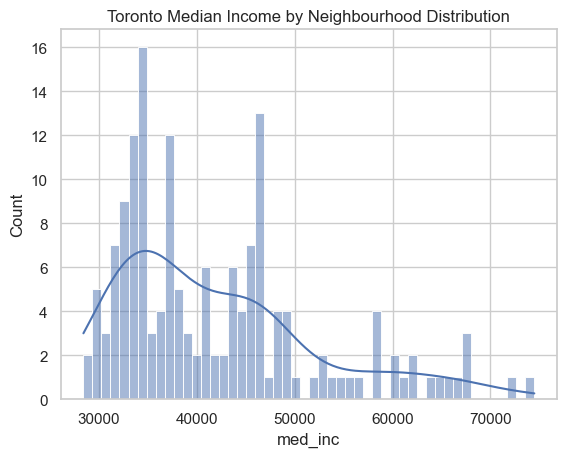

Shapiro-Wilk p-value: 0.000000004208


In [89]:
"""Test median income normality"""

# Qualitatively with a histogram
sns.histplot(toronto_inc_lst["med_inc"], bins=50, kde=True)
plt.title("Toronto Median Income by Neighbourhood Distribution")
plt.show()

# Quantitatively with the Shapiro-Wilk test
stat, p = shapiro(toronto_inc_lst["med_inc"])
print(f"Shapiro-Wilk p-value: {p:.12f}")

$H_0$: Median income by neighbourhood is not normally distributed  
$H_1$: Median income by neighbourhood is normally distributed

Based on visual assessment of the histogram and a Shapiro-Wilk p-value < 0.05 there is insufficient evidence to reject the null. Therefore, we fail to reject the null, i.e. the median income by neighbourhood data is likely not normally distributed.

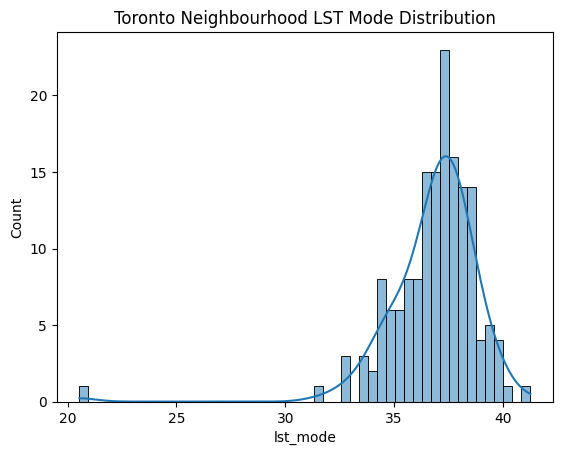

Shapiro-Wilk p-value: 0.000000000000


In [42]:
"""Assess LST mode normality"""

# Qualitatively with a histogram
sns.histplot(toronto_inc_lst["lst_mode"], bins=50, kde=True)
plt.title("Toronto Neighbourhood LST Mode Distribution")
plt.show()

# Quantitatively with the Shapiro-Wilk test
stat, p = shapiro(toronto_inc_lst["lst_mode"])
print(f"Shapiro-Wilk p-value: {p:.12f}")

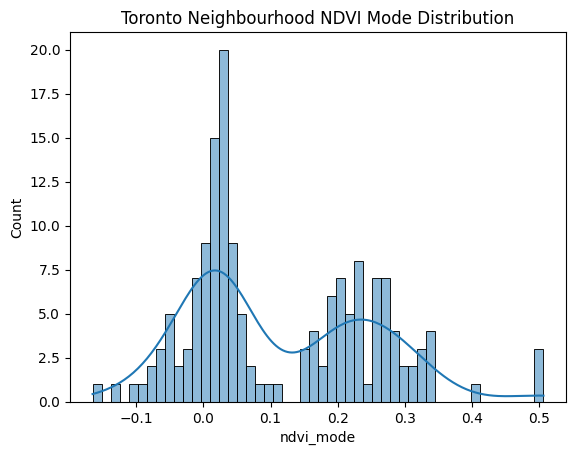

Shapiro-Wilk p-value: 0.000000609418


In [43]:
"""Assess NDVI mode normality"""

# Qualitatively with a histogram
sns.histplot(toronto_inc_lst["ndvi_mode"], bins=50, kde=True)
plt.title("Toronto Neighbourhood NDVI Mode Distribution")
plt.show()

# Quantitatively with the Shapiro-Wilk test
stat, p = shapiro(toronto_inc_lst["ndvi_mode"])
print(f"Shapiro-Wilk p-value: {p:.12f}")

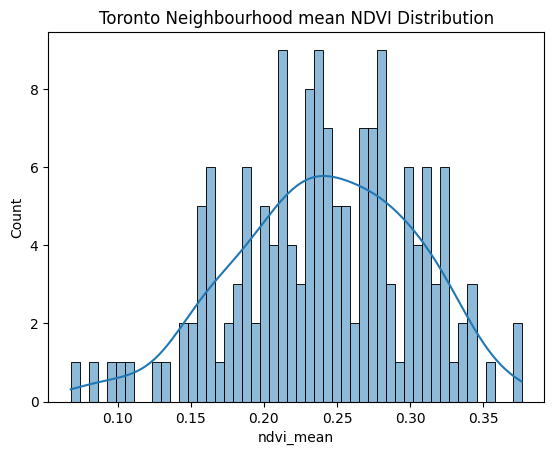

Shapiro-Wilk p-value: 0.312558625961


In [44]:
"""Assess mean NDVI normality"""

# Qualitatively with a histogram
sns.histplot(toronto_inc_lst["ndvi_mean"], bins=50, kde=True)
plt.title("Toronto Neighbourhood mean NDVI Distribution")
plt.show()

# Quantitatively with the Shapiro-Wilk test
stat, p = shapiro(toronto_inc_lst["ndvi_mean"])
print(f"Shapiro-Wilk p-value: {p:.12f}")

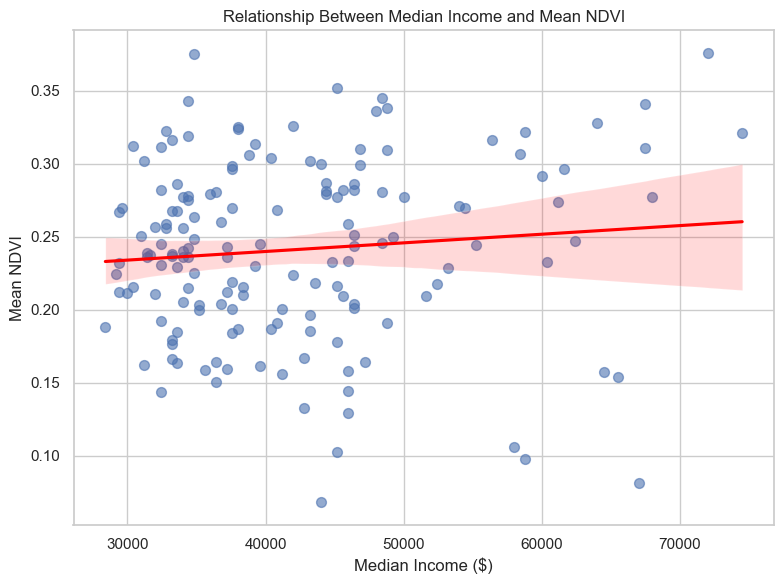

Pearson's r: 0.0993
Pearson's r: 0.2144
----------------------------------------------------------------------
Spearman's rank correlation: 0.1182
Spearman's rank p-value: 0.1391


In [95]:
"""Asses Median Income vs Mean NDVI"""

x="med_inc"
y="ndvi_mean"

# Create scatterplot with regression line
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.regplot(
    data=toronto_inc_lst,
    x=x,
    y=y,
    scatter_kws={"alpha": 0.6, "s": 50},
    line_kws={"color": "red"},
    ci=95
)

plt.xlabel("Median Income ($)")
plt.ylabel("Mean NDVI")
plt.title("Relationship Between Median Income and Mean NDVI")
plt.tight_layout()
plt.show()

# Calculate Pearson's r
corr, p = pearsonr(toronto_inc_lst[x], toronto_inc_lst[y])
print(f"Pearson's r: {corr:.4f}")
print(f"Pearson's r: {p:.4f}")
print(divider)

# Calculate Spearman's rank correlation
corr, p = spearmanr(toronto_inc_lst[x], toronto_inc_lst[y])
print(f"Spearman's rank correlation: {corr:.4f}")
print(f"Spearman's rank p-value: {p:.4f}")

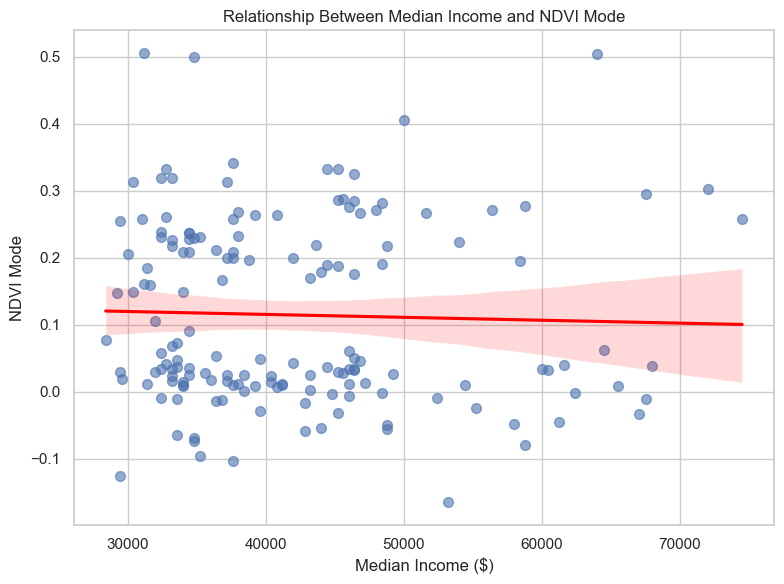

Pearson's r: -0.0324
Pearson's r: 0.6864
----------------------------------------------------------------------
Spearman's rank correlation: -0.0812
Spearman's rank p-value: 0.3105


In [97]:
"""Asses Median Income vs NDVI Mode"""

x="med_inc"
y="ndvi_mode"

# Create scatterplot with regression line
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.regplot(
    data=toronto_inc_lst,
    x=x,
    y=y,
    scatter_kws={"alpha": 0.6, "s": 50},
    line_kws={"color": "red"},
    ci=95
)

plt.xlabel("Median Income ($)")
plt.ylabel("NDVI Mode")
plt.title("Relationship Between Median Income and NDVI Mode")
plt.tight_layout()
plt.show()

# Calculate Pearson's r
corr, p = pearsonr(toronto_inc_lst[x], toronto_inc_lst[y])
print(f"Pearson's r: {corr:.4f}")
print(f"Pearson's r: {p:.4f}")
print(divider)

# Calculate Spearman's rank correlation
corr, p = spearmanr(toronto_inc_lst[x], toronto_inc_lst[y])
print(f"Spearman's rank correlation: {corr:.4f}")
print(f"Spearman's rank p-value: {p:.4f}")

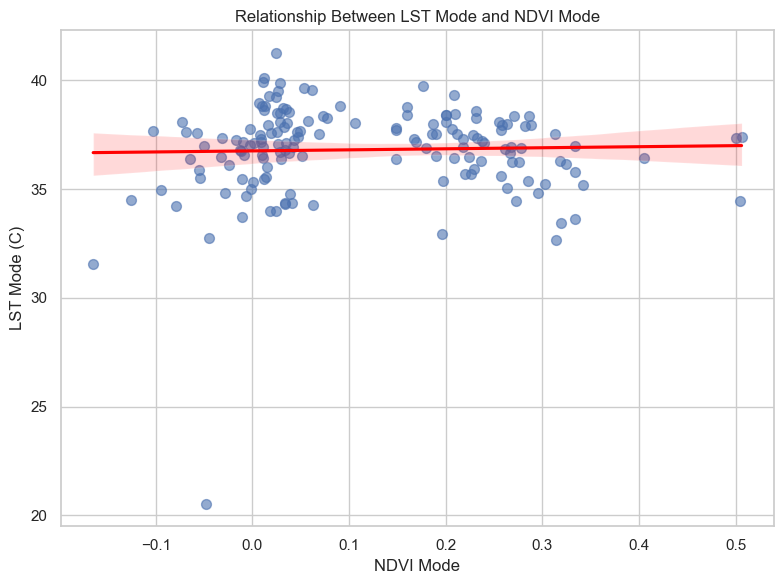

Pearson's r: 0.0315
Pearson's r: 0.6942
----------------------------------------------------------------------
Spearman's rank correlation: 0.0100
Spearman's rank p-value: 0.9007


In [98]:
"""Asses LST Mode vs NDVI Mode"""

x="ndvi_mode"
y="lst_mode"

# Create scatterplot with regression line
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.regplot(
    data=toronto_inc_lst,
    x=x,
    y=y,
    scatter_kws={"alpha": 0.6, "s": 50},
    line_kws={"color": "red"},
    ci=95
)

plt.xlabel("NDVI Mode")
plt.ylabel("LST Mode (C)")
plt.title("Relationship Between LST Mode and NDVI Mode")
plt.tight_layout()
plt.show()

# Calculate Pearson's r
corr, p = pearsonr(toronto_inc_lst[x], toronto_inc_lst[y])
print(f"Pearson's r: {corr:.4f}")
print(f"Pearson's r: {p:.4f}")
print(divider)

# Calculate Spearman's rank correlation
corr, p = spearmanr(toronto_inc_lst[x], toronto_inc_lst[y])
print(f"Spearman's rank correlation: {corr:.4f}")
print(f"Spearman's rank p-value: {p:.4f}")

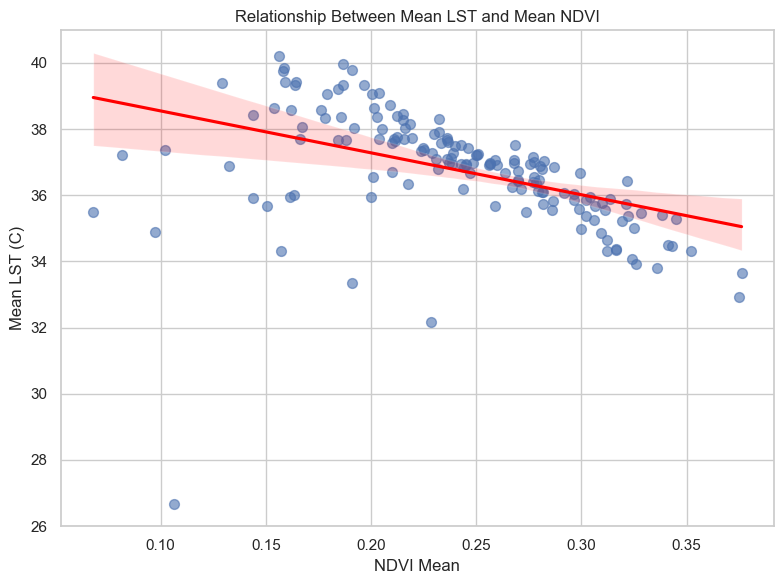

Pearson's r: -0.4506
Pearson's r: 0.0000
----------------------------------------------------------------------
Spearman's rank correlation: -0.6624
Spearman's rank p-value: 0.0000


In [96]:
"""Asses Mean LST vs Mean NDVI"""

x="ndvi_mean"
y="lst_mean"

# Create scatterplot with regression line
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.regplot(
    data=toronto_inc_lst,
    x=x,
    y=y,
    scatter_kws={"alpha": 0.6, "s": 50},
    line_kws={"color": "red"},
    ci=95
)

plt.xlabel("NDVI Mean")
plt.ylabel("Mean LST (C)")
plt.title("Relationship Between Mean LST and Mean NDVI")
plt.tight_layout()
plt.show()

# Calculate Pearson's r
corr, p = pearsonr(toronto_inc_lst[x], toronto_inc_lst[y])
print(f"Pearson's r: {corr:.4f}")
print(f"Pearson's r: {p:.4f}")
print(divider)

# Calculate Spearman's rank correlation
corr, p = spearmanr(toronto_inc_lst[x], toronto_inc_lst[y])
print(f"Spearman's rank correlation: {corr:.4f}")
print(f"Spearman's rank p-value: {p:.4f}")

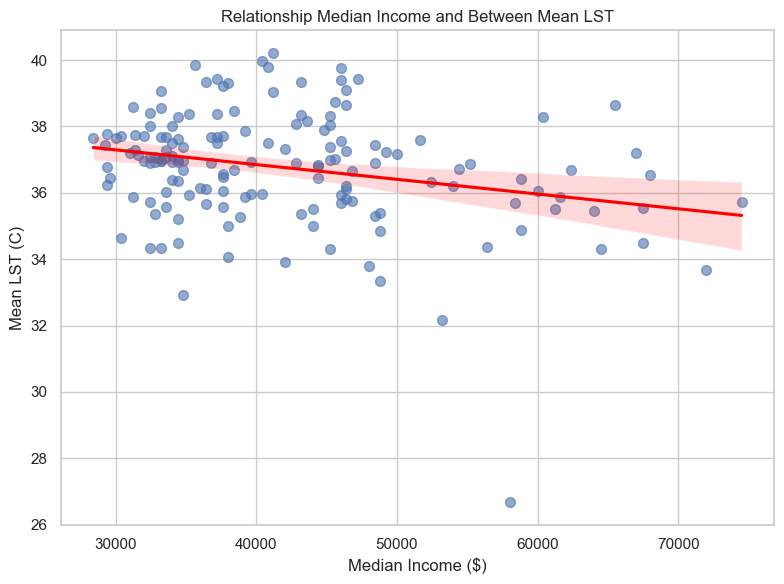

Pearson's r: -0.2649
Pearson's r: 0.0008
----------------------------------------------------------------------
Spearman's rank correlation: -0.2227
Spearman's rank p-value: 0.0049


In [104]:
"""Assess Median Income vs  Mean LST"""

x="med_inc"
y="lst_mean"

# Create scatterplot with regression line
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.regplot(
    data=toronto_inc_lst,
    x=x,
    y=y,
    scatter_kws={"alpha": 0.6, "s": 50},
    line_kws={"color": "red"},
    ci=95
)

plt.xlabel("Median Income ($)")
plt.ylabel("Mean LST (C)")
plt.title("Relationship Median Income and Between Mean LST")
plt.tight_layout()
plt.show()

# Calculate Pearson's r
corr, p = pearsonr(toronto_inc_lst[x], toronto_inc_lst[y])
print(f"Pearson's r: {corr:.4f}")
print(f"Pearson's r: {p:.4f}")
print(divider)

# Calculate Spearman's rank correlation
corr, p = spearmanr(toronto_inc_lst[x], toronto_inc_lst[y])
print(f"Spearman's rank correlation: {corr:.4f}")
print(f"Spearman's rank p-value: {p:.4f}")

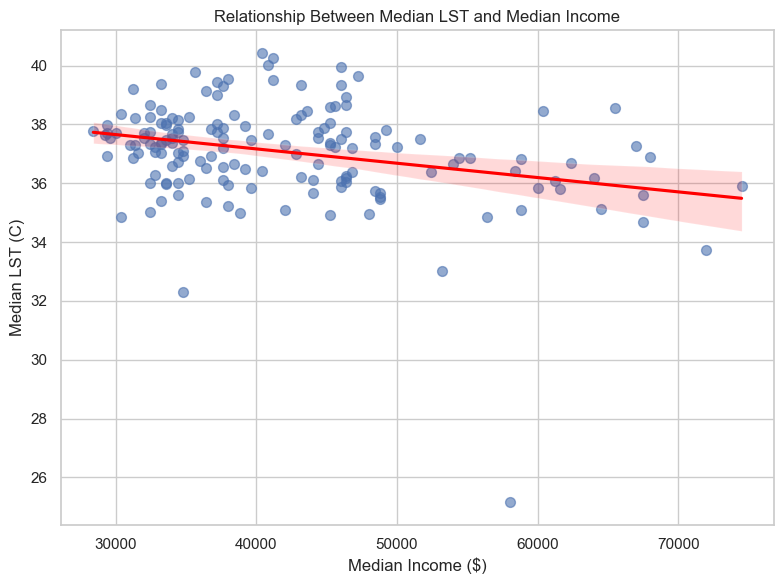

Pearson's r: -0.2961
Pearson's r: 0.0002
----------------------------------------------------------------------
Spearman's rank correlation: -0.2610
Spearman's rank p-value: 0.0009


In [100]:
"""Assess Median LST vs Median Income"""

x="med_inc"
y="lst_median"

# Create scatterplot with regression line
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.regplot(
    data=toronto_inc_lst,
    x=x,
    y=y,
    scatter_kws={"alpha": 0.6, "s": 50},
    line_kws={"color": "red"},
    ci=95
)

plt.xlabel("Median Income ($)")
plt.ylabel("Median LST (C)")
plt.title("Relationship Between Median LST and Median Income")
plt.tight_layout()
plt.show()

# Calculate Pearson's r
corr, p = pearsonr(toronto_inc_lst[x], toronto_inc_lst[y])
print(f"Pearson's r: {corr:.4f}")
print(f"Pearson's r: {p:.4f}")
print(divider)

# Calculate Spearman's rank correlation
corr, p = spearmanr(toronto_inc_lst[x], toronto_inc_lst[y])
print(f"Spearman's rank correlation: {corr:.4f}")
print(f"Spearman's rank p-value: {p:.4f}")

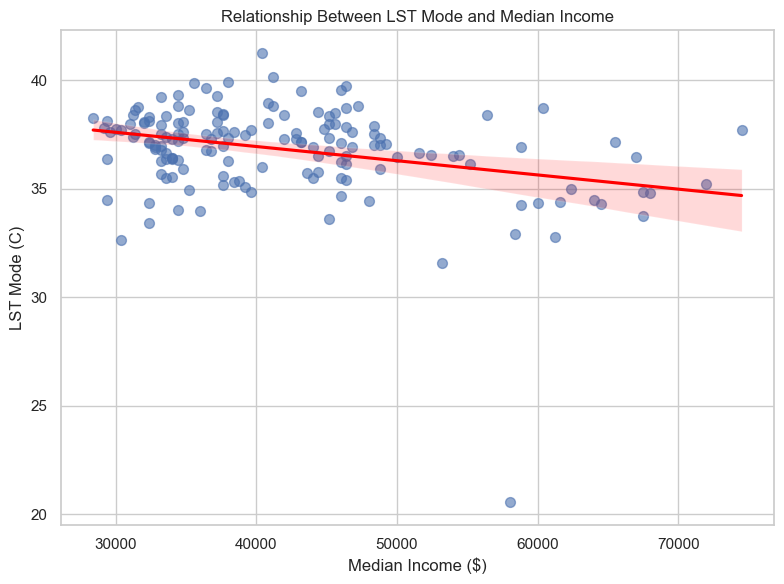

Pearson's r: -0.3189
Pearson's r: 0.0000
----------------------------------------------------------------------
Spearman's rank correlation: -0.2513
Spearman's rank p-value: 0.0014


In [101]:
"""Assess LST Mode vs Median Income"""

x="med_inc"
y="lst_mode"

# Create scatterplot with regression line
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.regplot(
    data=toronto_inc_lst,
    x=x,
    y=y,
    scatter_kws={"alpha": 0.6, "s": 50},
    line_kws={"color": "red"},
    ci=95
)

plt.xlabel("Median Income ($)")
plt.ylabel("LST Mode (C)")
plt.title("Relationship Between LST Mode and Median Income")
plt.tight_layout()
plt.show()

# Calculate Pearson's r
corr, p = pearsonr(toronto_inc_lst[x], toronto_inc_lst[y])
print(f"Pearson's r: {corr:.4f}")
print(f"Pearson's r: {p:.4f}")
print(divider)

# Calculate Spearman's rank correlation
corr, p = spearmanr(toronto_inc_lst[x], toronto_inc_lst[y])
print(f"Spearman's rank correlation: {corr:.4f}")
print(f"Spearman's rank p-value: {p:.4f}")

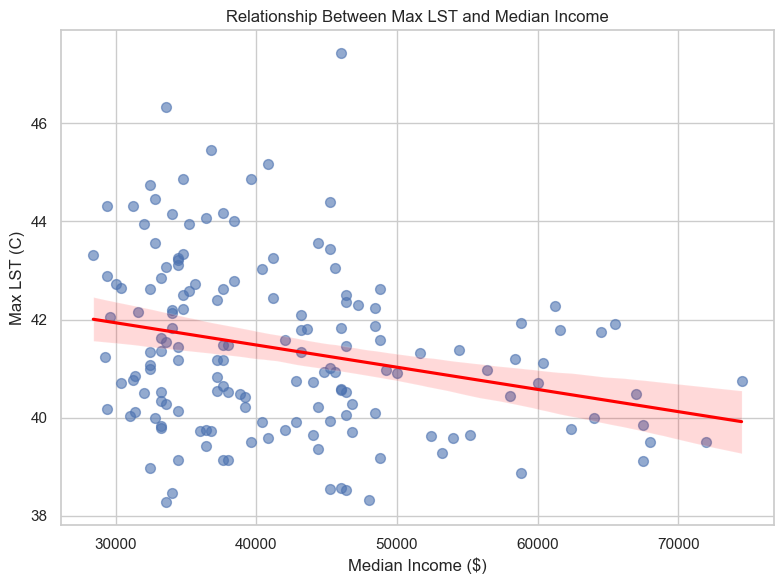

Pearson's r: -0.2670
Pearson's r: 0.0007
----------------------------------------------------------------------
Spearman's rank correlation: -0.2645
Spearman's rank p-value: 0.0008


In [102]:
"""Assess Max LST vs Median Income"""

x="med_inc"
y="lst_max"

# Create scatterplot with regression line
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.regplot(
    data=toronto_inc_lst,
    x=x,
    y=y,
    scatter_kws={"alpha": 0.6, "s": 50},
    line_kws={"color": "red"},
    ci=95
)

plt.xlabel("Median Income ($)")
plt.ylabel("Max LST (C)")
plt.title("Relationship Between Max LST and Median Income")
plt.tight_layout()
plt.show()

# Calculate Pearson's r
corr, p = pearsonr(toronto_inc_lst[x], toronto_inc_lst[y])
print(f"Pearson's r: {corr:.4f}")
print(f"Pearson's r: {p:.4f}")
print(divider)

# Calculate Spearman's rank correlation
corr, p = spearmanr(toronto_inc_lst[x], toronto_inc_lst[y])
print(f"Spearman's rank correlation: {corr:.4f}")
print(f"Spearman's rank p-value: {p:.4f}")

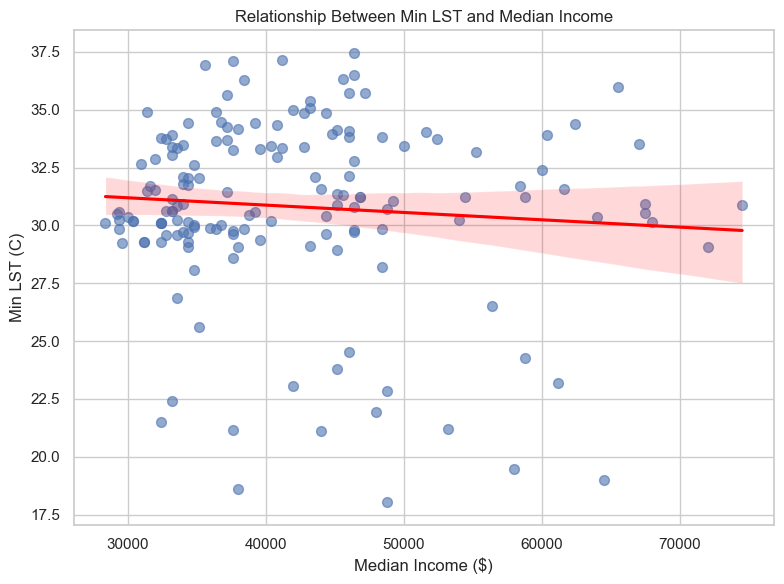

Pearson's r: -0.0840
Pearson's r: 0.2938
----------------------------------------------------------------------
Spearman's rank correlation: 0.0680
Spearman's rank p-value: 0.3958


In [103]:
"""Assess Min LST vs Median Income"""

x="med_inc"
y="lst_min"

# Create scatterplot with regression line
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.regplot(
    data=toronto_inc_lst,
    x=x,
    y=y,
    scatter_kws={"alpha": 0.6, "s": 50},
    line_kws={"color": "red"},
    ci=95
)

plt.xlabel("Median Income ($)")
plt.ylabel("Min LST (C)")
plt.title("Relationship Between Min LST and Median Income")
plt.tight_layout()
plt.show()

# Calculate Pearson's r
corr, p = pearsonr(toronto_inc_lst[x], toronto_inc_lst[y])
print(f"Pearson's r: {corr:.4f}")
print(f"Pearson's r: {p:.4f}")
print(divider)

# Calculate Spearman's rank correlation
corr, p = spearmanr(toronto_inc_lst[x], toronto_inc_lst[y])
print(f"Spearman's rank correlation: {corr:.4f}")
print(f"Spearman's rank p-value: {p:.4f}")

### References:

Toronto, C. O. (2024, August 12). *Open data.* City of Toronto. https://www.toronto.ca/city-government/data-research-maps/open-data/

U.S. Geological Survey (n.d.). *EarthExplorer.* https://earthexplorer.usgs.gov/